In [3]:
    from IPython.core.display import HTML
    
    def css_styling():
        styles = open("custom.css", "r").read()
        return HTML(styles)
    css_styling()


# Biophysical parameter retrieval with ``eoldas_ng``

#### J Gómez-Dans (NCEO & UCL)



## Introduction

In this practical, we consider the problem of extracting meaningful biophysical parameters from optical Earth Observation (EO) data. More concretely, we will use **bihemispherical broadband albedoes** as our input, interpret them through a simple **two-stream radiative transfer scheme** in order to retrieve a handful of parameters which are of interest in a large number of applications:

1. Parameters related to leaf reflectance and transmittance in the visible and near-infrarred regions of the spectrum,
2. Parameters describing the albedo of the soil under the vegetation,
3. The *amount of vegetation*, expressed through an *effective* leaf area index (LAI).

The two stream model has been used both for parameter retrieval (as we shall do here), but has also been implemented in a number of dynamic global vegetation models (DGVMs). This means that the parameters that are retrieved here will be strictly compatible with the same concepts in the DGVM, making them directly useable.

In this practical, we consider that the main role of the vegetation is in **flux partitioning**, or in other words,the amount of radiation that is absorbed by the canopy to be further used in photosynthesis, for example. 

## Bits 'n' bobs

### The input data

A number of albedo products exist, such as the [GlobAlbedo product](http://globalbedo.org) or the [MODIS albedo product](https://www.umb.edu/spectralmass/terra_aqua_modis/v006/mcd43a2_albedo_product). In either of these cases, the products produce an estimate of the **bi-hemispherical reflectance** (BHR) (or *white sky albedo*) for a particular area at a particular time. The differences in these prodcuts are to do with whether data from one particular sensor was used, but are broadly comparable.

We have extracted some data from the MODIS Collection 5 albedo product over a number of [FLUXNET sites](http://fluxnet.ornl.gov/). These are:

| Site code | Site Name |
|-----------|-----------|
|AU-Tum | Tumbarumba|
|BR-Cax | Caxiuana Forest-Almeirim|
|CA-Ca1 | BC-Campbell River 1949 Douglas-fir|
|DE-Geb | Gebesee|
|DE-Hai | Hainich|
|ES-LMa | Las Majadas del Tietar|
|FI-Hyy | Hyytiala|
|FR-Lam | Lamasquere|
|IT-SRo | San Rossore|
|RU-Ylr | Yakutsk-Larch|
|SE-Abi | Abisko|
|US-Bar | Bartlett Experimental Forest|
|US-Bo1 | Bondville|
|US-Brw | Barrow |
|US-Dk2 | Duke Forest Hardwoods|
|US-Ha2 | Harvard Forest Hemlock Site|
|US-MMS | Morgan Monroe State Forest|
|US-Me2 | Metolius Intermediate Pine|
|US-Me3 | Metolius Second Young Pine|
|US-Ne1 | Mead - irrigated continuous maize site|
|US-Ne2 | Mead - irrigated maize-soybean rotation site|
|US-Ne3 | Mead - rainfed maize-soybean rotation site|
|US-Ton | Tonzi Ranch|
|ZA-Kru | Skukuza|

We will now visualise and explore the MODIS C5 BHR data a bit with the next code snippet...

<div class="warn">
To run this, just press on the **"play button"** on the main toolbar
</div>


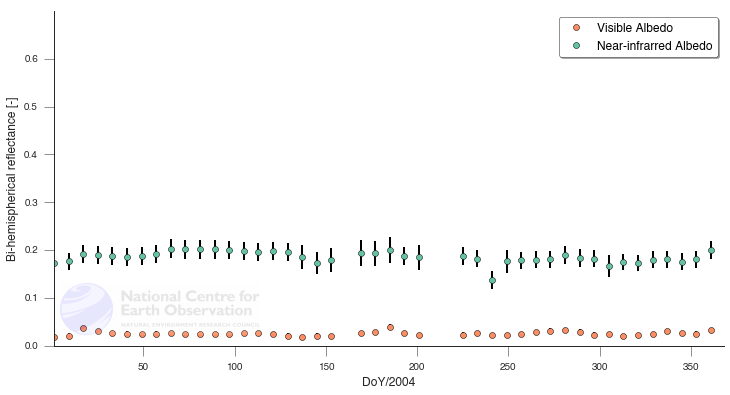

In [4]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

from da_gui import *

visualise_albedos()

<div class="question">
<ul>
<li> What are the main processes that are obvious in the data?</li>
<li> How can you relate them to the site in question?</li>
<li> Think of this in terms of radiation fluxes. What is this data telling you?</li>
</ul>
</div>

## The radiative transfer (RT) model

We will use the "two stream" radiative transfer model of ([Pinty et al. (2007)](http://citeseerx.ist.psu.edu/viewdoc/download?doi=10.1.1.131.4066&rep=rep1&type=pdf) (but also [Pinty et al, (2011)](http://onlinelibrary.wiley.com/doi/10.1029/2010JD015372/full) and others). This is a fairly simple model that has been designed to monitor radiation fluxes in the land surface. 

The model has 7 parameters:

1. Leaf **single scattering albedo** in the VISIBLE
2. Leaf **anysotropy** in the VISIBLE
3. Background **soil albedo** in the VISIBLE
4. Leaf **single scattering albedo** in the NIR
5. Leaf **anysotropy** in the NIR
6. Background **soil albedo** in the NIR
7. **Effective** leaf area index (**LAI**)

These parameters are all that's necessary to describe the fluxes in a canopy. The price paide for this simplification is that the complexities of the 3D structure of the vegetation are dealt with by using an *effective* LAI. This LAI is different to the *true* LAI (with e.g. discontinuous crown clumping, etc.), but from the point of calculating fluxes like $fAPAR$, it is entirely equivalent, and simplifies things enormously.

![TIP](http://romc.jrc.ec.europa.eu/WWW/PAGES/ROMC_Home/MISCELLANEOUS/HOM01.gif)

The model describes the canopy in terms of the leave abundance, and by the optical properties of leaves. A soil background is also included. 

The use of spectral broadbands allows for a fairly simple description of leaf optical properties, which coupled with the amount of vegetation define the vegetation optical depth.

If the vegetation is abundant, the effect of the soil will be negligible, as few photons will escape the canopy. However, if the soil is very bright (e.g. snow), this might be quite a significant amount. Also note that the vegetation optical depth is defined by the combination of leaf abundance as well as optical properties, so it is perfectly feasible to have the same albedos for two completely different canopies (e.g. one with low LAI and highly reflecting leaves, and one with darker leaves and high LAI). 



## The inversion using ``eoldas_ng``

In ``eoldas_ng``, we will solve the **inverse problem** of estimating the land surface parameters from albedo measurements (the forward problem is the simulation of albedo when the land surface parameters are known). For notational convenience, we stack the seven TIP parameters into a columnt vector $\vec{x}=\left[ \omega_{VIS}, d_{VIS}, a_{VIS}, \omega_{NIR}, d_{NIR}, a_{NIR}, LAI_{e}\right]^{\top}$. The TIP model will be $\mathcal{H}$, and it predicts $\alpha_{VIS}$ and $\alpha_{NIR}$:

$$
\mathcal{H}(\vec{x}) = \left[\alpha_{VIS}, \alpha_{NIR}\right]^{\top}.
$$

The measurements of albedo are given by $\vec{R}$ (a two-element vector). Under the assumption that these measurements are contaminated by zero-mean Gaussian noise, we can write the **generative model of the observations** as

$$
\vec{R} = \mathcal{H}(\vec{x}) + \mathcal{N}(0,\mathbf{C}_{obs}).
$$

This gives rise to the (log)likelihood function

$$
p(\vec{R}|\vec{x})\propto \frac{1}{2}\left[\mathcal{H}(\vec{x}) - \vec{R}\right]^{\top}\mathbf{C}_{obs}^{-1}\left[\mathcal{H}(\vec{x}) - \vec{R}\right].
$$

We can minimise this function, but given the nature of $\mathcal{H}$ and the noise in the observations, there will be infinite solutions that pass through the measurements, so the problem is *ill posed*.

A better way is to try to supplement the observations with prior distributions of parameters, e.g. $p(\vec{x})$. If we assume that the prior distribution are normal, the likelihood is normal and we make an assumption on $\mathcal{H}$ not being too non-linear, then we can use **Bayes' Rule** to write the **probability distribution** of $\vec{x}$ when the observations $\vec{R}$ have been considered:

$$
p(\vec{x}|\vec{R})\propto \overbrace{p(\vec{x})}^{\textrm{A priori}}\cdot\underbrace{p(\vec{R}|\vec{x})}_{\textrm{Likelihood}}.
$$

It turns out that

1. We can assume $p(\vec{x}|\vec{R})$ to be **Normal**
2. Its mean vector is given by the *maximum a posteriori* (or MAP) value
3. Its covariance matrix is given by the inverse of the Hessian matrix at the MAP point.

Further, rather than solve for the MAP directly, we can solve for the value of $\vec{x}$ that minimises the **log posterior**, and we can use **gradient descent methods** for this.

``eoldas_ng`` makes all this easy to set-up. We will put some priors on parameters, and solve for each observation independently...

### The prior

We will use the prior distribution given by Pinty et al. (2011). Broadly, this is:

![the tip prior](tip_priors.png)

![the tip prior table](tip_prior_table.png)

<div class="question">
<p>The prior has already been coded up for you to use. The following widget will allow you to select a site and year, and to run the TIP inversion on the albedo data, using the TIP prior as seen above. </p>
</div>

<div class="question">
<p>In the plots, the grey areas show the <strong>prior</strong> area (mean $\pm$ 1 standard deviation. The vertical lines show the <strong>posterior</strong> area, and the line shows the prior mean (orange, dashed) and posterior mean (green, dots) </p>
</div>




Saving results to eoldas_retval_20160806_175407_cubil


tip_inversion.py:111: VisibleDeprecationWarning: boolean index did not match indexed array along dimension 0; dimension is 46 but corresponding boolean dimension is 36
  if passer_snow[i]:
/opt/anaconda/lib/python2.7/site-packages/scipy/sparse/coo.py:359: SparseEfficiencyWarning: Constructing a DIA matrix with 322 diagonals is inefficient
  "is inefficient" % len(diags), SparseEfficiencyWarning)


[11.098511242784376, 14.724794718970111, 10.210895454527513, 10.707608472326941, 11.7133339997026]
Chosen cost: 10.2109


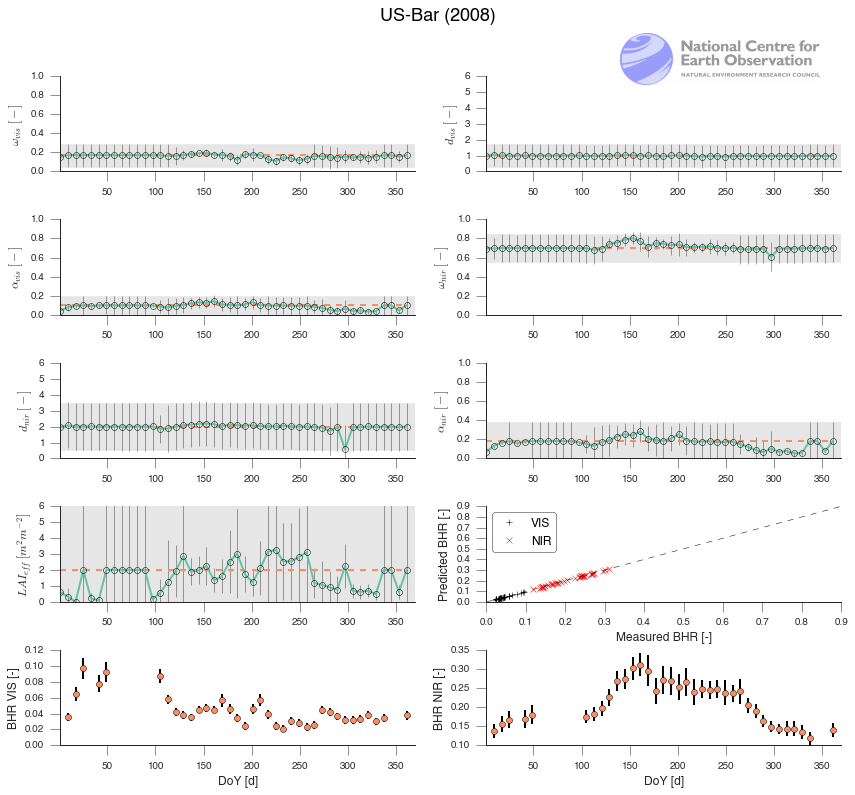

In [5]:
single_observation_inversion()

<div class="question">
<ul>
<li> Is the solution able to reproduce the observations well?
<li> What can we say about the posterior mean for most parameters?
<li> Is there a parameter where the posterior mean is consistently very different from the prior?
<li> What about the prior vs posterior uncertainties?
<li> What happens when there's no data?
<li> What can you say about the uncertainty in e.g. LAI?
</ul>
</div>